In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import scipy
import skimage
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log
import nuclei
from skimage.transform import resize
from IPython.core.debugger import set_trace

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

NUCLEI_DIR = "../../input"

/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
config = nuclei.NucleiConfig()
config.display()
print(MODEL_DIR)


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               400
MEAN_PIXEL                     [44.57284587, 40.71265898, 48.6901747]
MINI_MASK_SHAPE                (224, 224)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
dataset = nuclei.NucleiDataset()
dataset.load_nuclei(NUCLEI_DIR, "train")
dataset.prepare()

dataset_test = nuclei.NucleiDataset()
dataset_test.load_nuclei(NUCLEI_DIR, "test")
dataset_test.prepare()

In [5]:
dataset_train, dataset_val = dataset.extract_train_val()
dataset_train.prepare()
dataset_val.prepare()

In [6]:
len(dataset_val.image_ids)

34

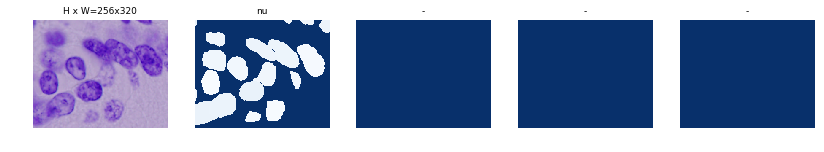

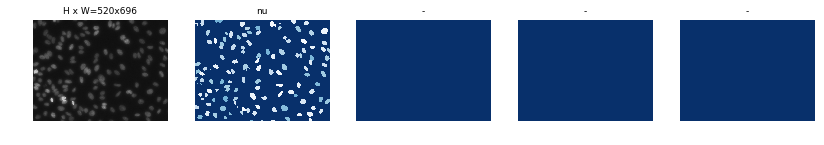

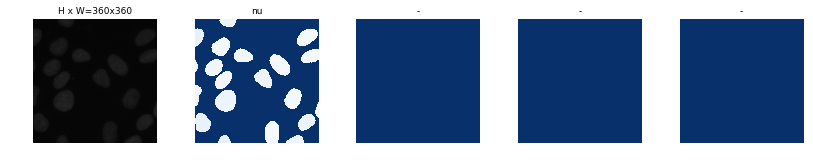

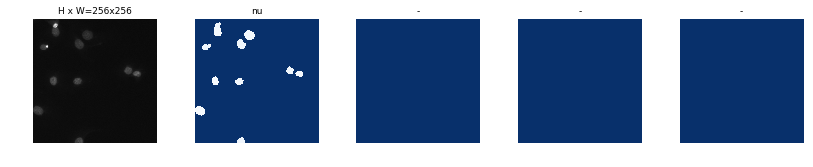

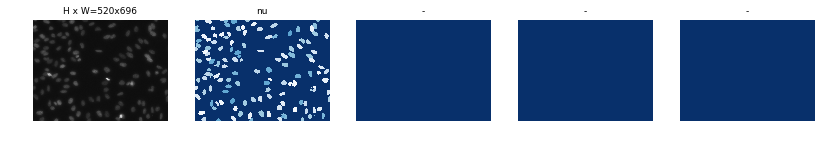

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 4)
image_ids = np.append(image_ids, [31])
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

## Ceate Model

In [18]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [19]:
print(MODEL_DIR)

/home/ubuntu/nuclei/solutions/kmrcnn/logs


In [20]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

print(model.log_dir)

/home/ubuntu/nuclei/solutions/kmrcnn/logs/nuclei20180223T0354


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_val, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10000, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_val, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=2000, 
            layers="all")


Starting at epoch 107. LR=0.0001

Checkpoint Path: /home/ubuntu/nuclei/solutions/kmrcnn/logs/nuclei20180223T0354/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (

/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 108/2000
34/34 [==============================] - 327s 10s/step - loss: 0.1715 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.1212 - val_loss: 0.0543 - val_rpn_class_loss: 8.6106e-05 - val_rpn_bbox_loss: 0.0027 - val_mrcnn_class_loss: 0.0049 - val_mrcnn_bbox_loss: 0.0034 - val_mrcnn_mask_loss: 0.0433
Epoch 109/2000
34/34 [==============================] - 174s 5s/step - loss: 0.1841 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.1237 - val_loss: 0.0641 - val_rpn_class_loss: 8.0347e-05 - val_rpn_bbox_loss: 0.0031 - val_mrcnn_class_loss: 0.0116 - val_mrcnn_bbox_loss: 0.0036 - val_mrcnn_mask_loss: 0.0457
Epoch 110/2000
34/34 [==============================] - 171s 5s/step - loss: 0.1728 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0092 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.1219 - val_loss: 0.0572 - 

## Detection

In [11]:
class InferenceConfig(nuclei.NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/nuclei/solutions/kmrcnn/logs/nuclei20180223T0354/mask_rcnn_nuclei_0106.h5


8
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9
Thresh	TP	FP	FN	Prec.
0.500	183	0	0	1.000
0.550	183	0	0	1.000
0.600	183	0	0	1.000
0.650	183	0	0	1.000
0.700	183	0	0	1.000
0.750	183	0	0	1.000
0.800	183	0	0	1.000
0.850	183	0	0	1.000
0.900	183	0	0	1.000
0.950	183	0	0	1.000
AP	-	-	-	1.000
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  233.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (183,)                min:    1.00000  max:    1.00000
gt_bbox                  shape: (183, 4)              min:    0.00000  max: 1023.00000
gt_mask                  shape: (1024, 1024, 183)     min:    0.00000  max:  255.00000


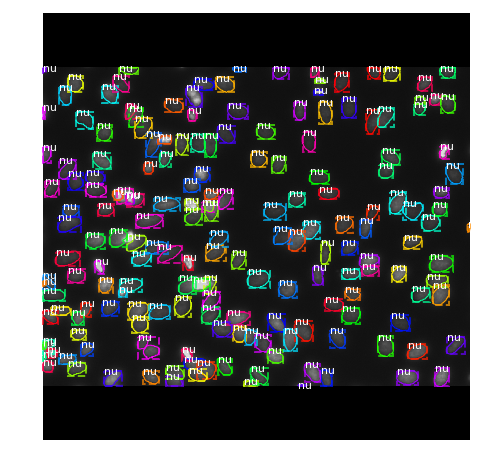

In [12]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
image_id = 8
print(image_id)
print(dataset_val.image_info[image_id]['id'])
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

pred_mask, ground_mask = utils.resh_to_orig(gt_mask, image_meta, dataset=dataset_val)

# # Test the IoU, Ralph!
utils.iou_metric(ground_mask,pred_mask,print_table=True)


log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

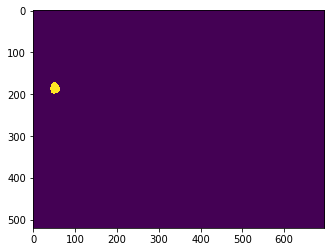

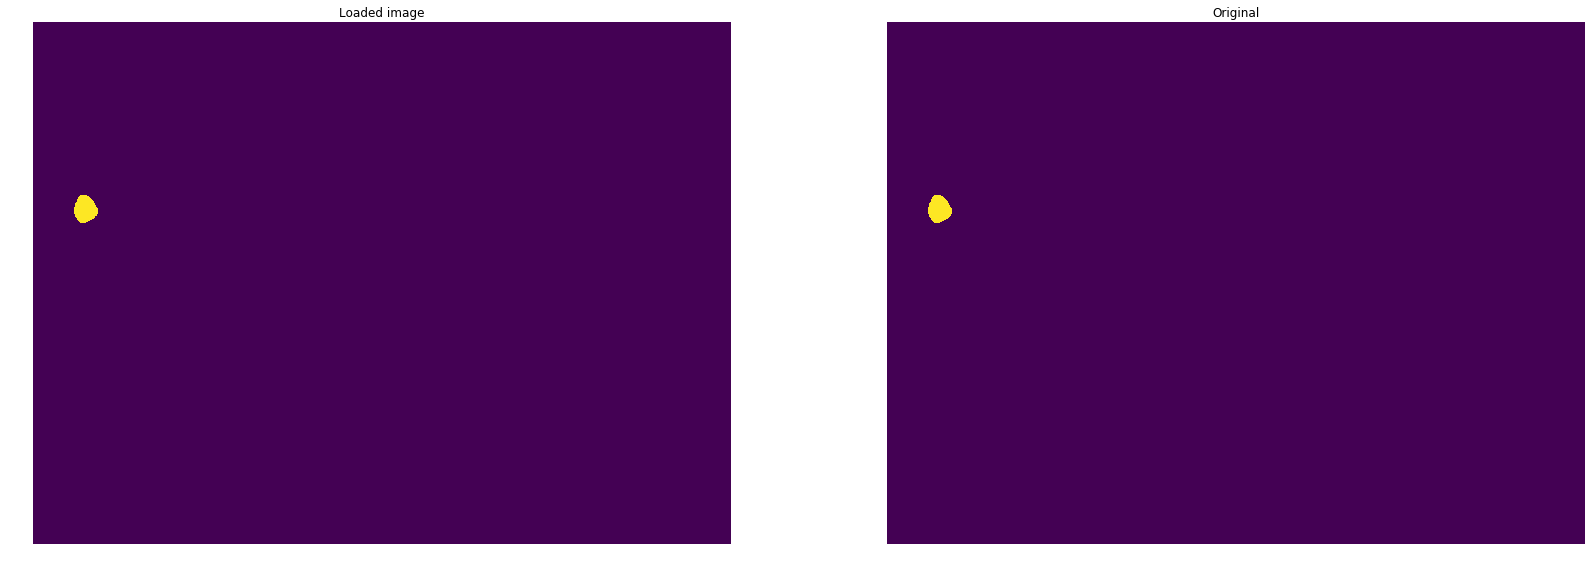

In [15]:
plt.imshow(pred_mask[:,:,0])
# Show label image
fig, axes = plt.subplots(1,2, figsize=(24,8))
axes[0].imshow(pred_mask[:,:,0])
axes[0].set_title("Loaded image")
axes[1].imshow(ground_mask[:,:,0])
axes[1].set_title("Original")
plt.tight_layout()
for ax in axes:
    ax.axis('off')

In [13]:
(pred_mask == ground_mask).any()

True

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  233.00000
molded_images            shape: (1, 1024, 1024, 3)    min:  -48.69017  max:  192.28734
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
(1024, 1024, 178)


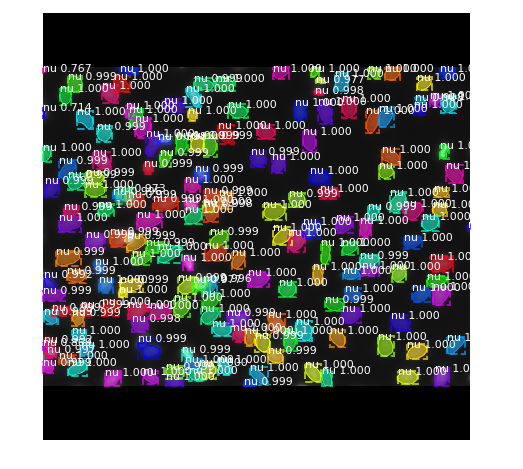

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
print(r['masks'].shape)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [15]:
r.keys()

dict_keys(['rois', 'class_ids', 'scores', 'masks'])

In [16]:
# Compute competition mAP @ different iou thresholds
# iou_metric(ground_mask,)
r['masks'].shape
pred_mask, ground_mask = utils.resh_to_orig(r['masks'], image_meta, dataset=dataset_val)
log('pred_mask',pred_mask)
log('ground_mask',ground_mask)
utils.iou_metric(ground_mask,pred_mask,print_table=True)

pred_mask                shape: (520, 696, 178)       min:    0.00000  max:    1.00000
ground_mask              shape: (520, 696, 183)       min:    0.00000  max:    1.00000
Thresh	TP	FP	FN	Prec.
0.500	176	2	7	0.951
0.550	175	3	8	0.941
0.600	175	3	8	0.941
0.650	174	4	9	0.930
0.700	173	5	10	0.920
0.750	168	10	15	0.870
0.800	156	22	27	0.761
0.850	114	64	69	0.462
0.900	38	140	145	0.118
0.950	0	178	183	0.000
AP	-	-	-	0.689


0.6894393282200396

In [17]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 34)
image_ids = dataset_val.image_ids
APs = []
print(image_ids.shape)
program_starts = time.time()
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    # molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    # AP, precisions, recalls, overlaps =\
        # utils.compute_ap(gt_bbox, gt_class_id,
                         # r["rois"], r["class_ids"], r["scores"])
    pred_mask, ground_mask = utils.resh_to_orig(r['masks'], image_meta, dataset=dataset_val)
    AP = utils.iou_metric(ground_mask,pred_mask)
    if AP < 0.8:
        print(image_id)
        print(dataset_val.image_info[image_id]['id'])
        print(AP)
        # continue
    # print(AP)
    APs.append(AP)
print("It has been {0} minutes since the loop started".format((time.time() - program_starts)/60))
print("mAP: ", np.mean(APs))


(34,)
1
a815a986800a95de0957116c6585deea8ffb6ee09ad00ccc687306937ac698d0
0.7321870584658308
3
a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7
0.7909018593922468
4
4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e
0.7684786093471532
5
ce88df7356d9d4a8d5944a93768f4c4b593de2d35616f7448c2b37b9fd60dd1f
0.7815371690857378
6
5b0bde771bc67c505d1b59405cbcad0a2766ec3ee4e35852e959552c1b454233
0.7048930481283422
7
1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5
0.79096918767507
8
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9
0.6894393282200396
9
5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9138dc49492a29ce856
0.7657468148549743
11
094afe36759e7daffe12188ab5987581d405b06720f1d5acf3f2614f404df380
0.6994635144316513
12
9520aff4efe87bd8f3901652fa2dde9b4bc9c679325966145ce00c1ca33f35de
0.7603661132396765
15
54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12
0.5494604296269603
18
92e7e86e765e05ce331c07a6d14f0a696eac7ee40058

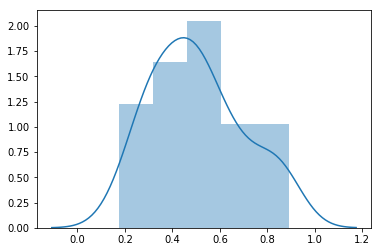

In [20]:
import seaborn as sns
sns.distplot(APs)

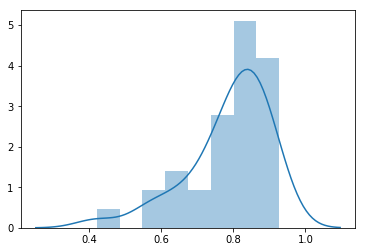

In [20]:
import seaborn as sns
sns.distplot(APs)

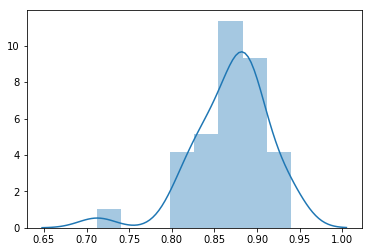

In [33]:
import seaborn as sns
sns.distplot(APs)